In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

#spark = SparkSession.builder.getOrCreate()
spark = SparkSession.builder.master("local[10]").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

df = spark.read.parquet("parquet/run1039_mwdc.parquet")
df.show(5)

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
26/01/15 23:20:04 WARN Utils: Your hostname, gpuana02, resolves to a loopback address: 127.0.1.1; using 192.168.1.216 instead (on interface enp4s0)
26/01/15 23:20:04 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
26/01/15 23:20:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/15 23:20:05 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
26/01/15 23:20:05 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
26/01/15 23:20:05 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
26/01/15 23:20:05 WARN Utils: Se

+---------+-----------+-----------+---------------+---------------+----------+-----------+---------------+---------------+----------+-----------+---------------+---------------+----------+-----------+---------------+---------------+-----------+-----------+---------------+---------------+----------+-----------+---------------+---------------+-----------+-----------+---------------+---------------+----------+-----------+---------------+---------------+----------+-----------+---------------+---------------+----------+-----------+---------------+---------------+----------+-----------+---------------+---------------+----------+-----------+---------------+---------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+-------------------+-------------------+------------------+-------------------+-------+
|hbfNumber| dc31_x1_dl|dc31_x1_id0|dc31_x1_charge0|dc31_x1_timing0|dc31_x2_dl|dc31

Statistics:
[[    0.   734.     0.]
 [    0. 17397.     0.]
 [    0.    63.     0.]]
Statistics:
[[    0.     0.     0.]
 [    0. 17052.     0.]
 [    0.   592.     0.]]
Statistics:
[[0.0000e+00 2.6700e+02 0.0000e+00]
 [0.0000e+00 1.7735e+04 0.0000e+00]
 [0.0000e+00 1.2000e+01 0.0000e+00]]
Statistics:
[[    0.     0.     0.]
 [    0. 17436.     0.]
 [    0.   312.     0.]]
Statistics:
[[    0.   674.     0.]
 [    0. 17502.     0.]
 [    0.   210.     0.]]
Statistics:
[[    0.     0.     0.]
 [    0. 16931.     0.]
 [    0.   523.     0.]]
Statistics:
[[    0.  2223.     0.]
 [    0. 16690.     0.]
 [    0.   662.     0.]]
Statistics:
[[    0.     0.     0.]
 [    0. 15348.     0.]
 [    0.   907.     0.]]
Statistics:
[[    0.     0.     0.]
 [    0. 16568.     0.]
 [    0.   668.     0.]]
Statistics:
[[    0.   976.     0.]
 [    0. 17458.     0.]
 [    0.   160.     0.]]
Statistics:
[[    0.     0.     0.]
 [    0. 18557.     0.]
 [    0.     0.     0.]]
Statistics:
[[    0.     0.  

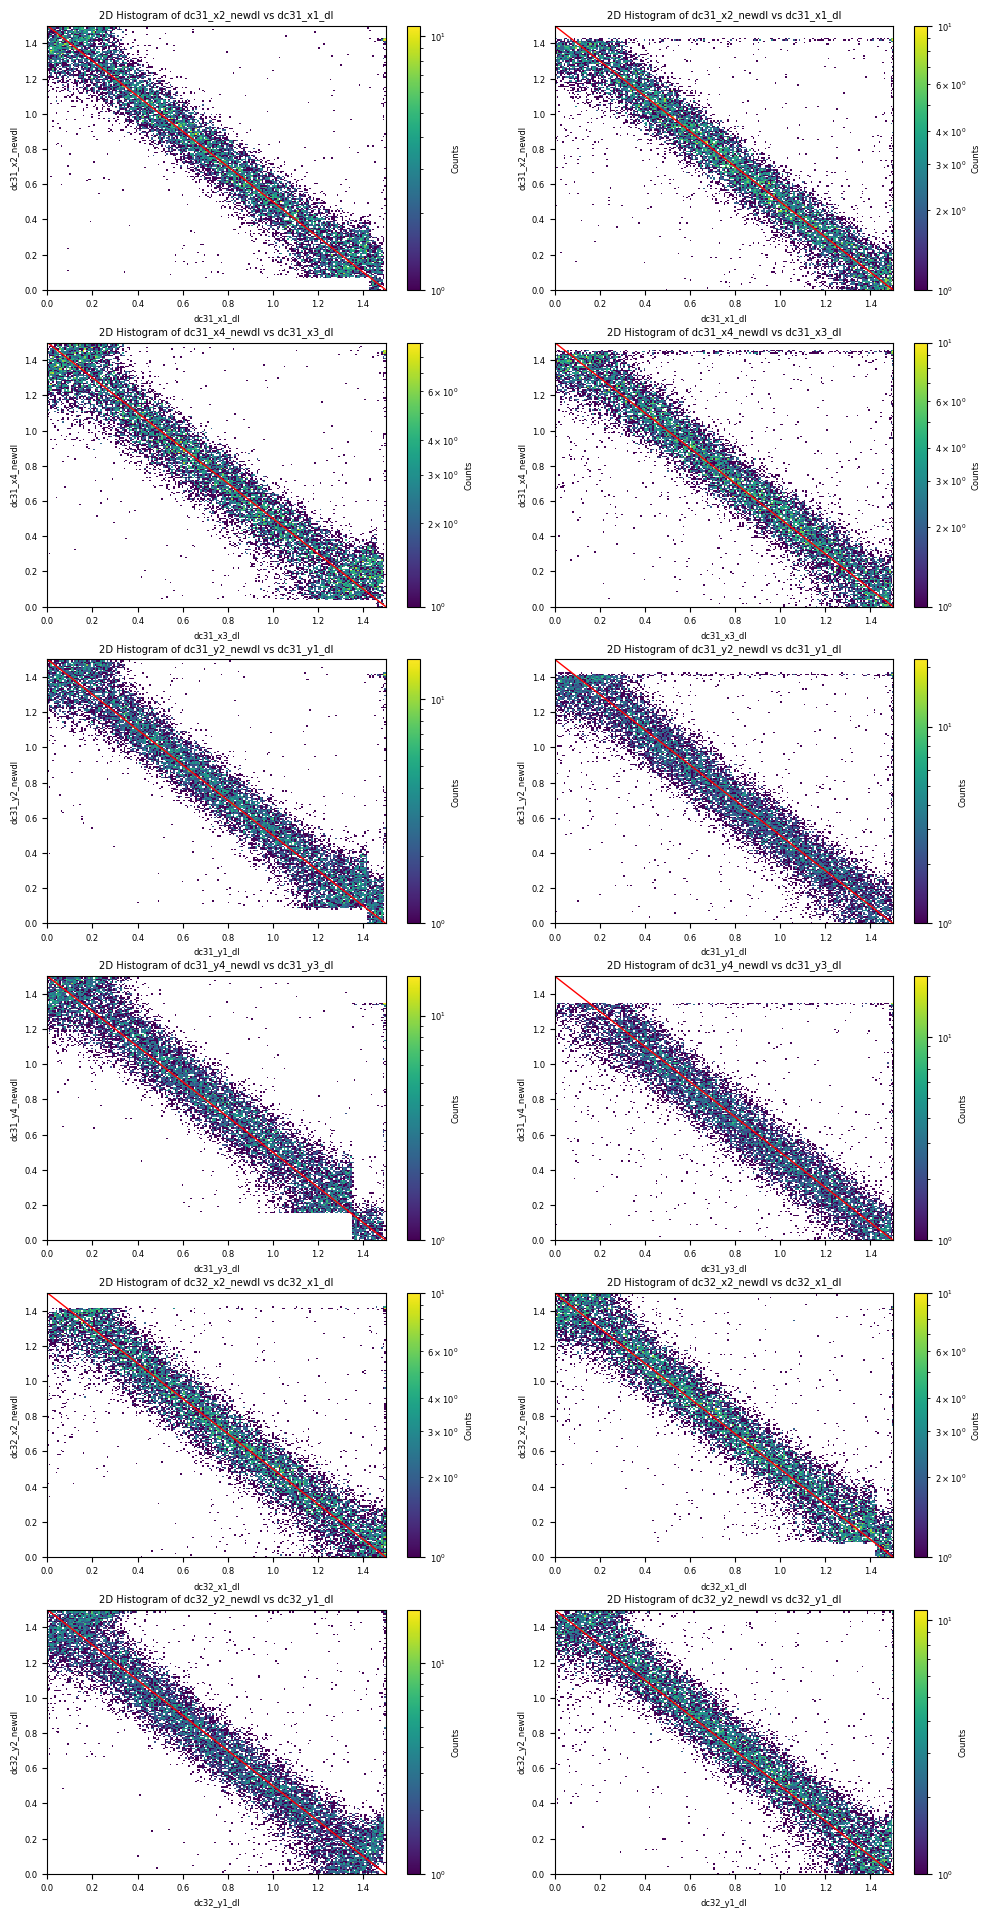

In [2]:
planes = [('dc31_x1', 'dc31_x2'), ('dc31_x3', 'dc31_x4'), ('dc31_y1', 'dc31_y2'), ('dc31_y3', 'dc31_y4'), ('dc32_x1', 'dc32_x2'), ('dc32_y1', 'dc32_y2')]
shifts = [0.07, 0.04, 0.08, 0.15, -0.08, 0.0]
cellsize = 3.0

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from hist.sparkHist2d import Hist2D

plt.figure(0, figsize=(12,24))
plt.rcParams["font.size"] = 6
for i, plane_pair in enumerate(planes):
    shift2 = shifts[i]
    plane1, plane2 = plane_pair
    if shift2 > 0:
        outdataframe = df.withColumn(
            plane2 + "_newdl",
            F.when(F.col(plane1 + "_id0") != F.col(plane2 + "_id0"),
                   F.col(plane2 + "_dl") - shift2)
            .when((F.col(plane1 + "_id0") == F.col(plane2 + "_id0")) & 
                  (F.col(plane1 + "_dl") > cellsize / 2 - shift2),
                   F.col(plane2 + "_dl") - shift2)
            .otherwise(F.col(plane2 + "_dl") + shift2)
        )
    else:
        outdataframe = df.withColumn(
            plane2 + "_newdl",
            F.when(F.col(plane1 + "_id0") == F.col(plane2 + "_id0"),
                   F.col(plane2 + "_dl")+ shift2 )
            .when((F.col(plane1 + "_id0") != F.col(plane2 + "_id0")) & 
                  (F.col(plane1 + "_dl") > cellsize / 2 - abs(shift2)),
                   F.col(plane2 + "_dl")+shift2)
            .otherwise( F.col(plane2 + "_dl")-shift2)
        )
    
    plt.subplot2grid((6,2),(i,0))
    d = Hist2D(outdataframe.filter(f"{plane1}_id0 == {plane2}_id0"), [f"{plane1}_dl",f"{plane2}_newdl"],[200,200],[[0,1.5],[0,1.5]],  interpolation='none', norm=LogNorm())
    plt.plot([0, 1.5], [1.5, 0], 'r-', linewidth=1)
    plt.subplot2grid((6,2),(i,1))
    d = Hist2D(outdataframe.filter(f"{plane1}_id0 != {plane2}_id0"), [f"{plane1}_dl",f"{plane2}_newdl"],[200,200],[[0,1.5],[0,1.5]],  interpolation='none', norm=LogNorm())
    plt.plot([0, 1.5], [1.5, 0], 'r-', linewidth=1)

plt.show()